In [315]:
#@title
# NB!!!
# Basta avviare una volta sola ad inizio sessione.
# Drive verrà montato per tutto il notebook

# from google.colab import drive
# drive.mount('/content/drive')

In [316]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **PIzze e Predizioni**

Un nostro amico ha appena aperto una pizzeria e vuole capire in che modo ottimizzare l'impiego delle materie prime per le pizze da cuocere  durante la giornata.

Come prima richiesta, ci chiede che il nostro programma sia capace di dare una predizione di massima sul numero di pizze da fare durante la giornata.

Per la seconda richiesta, ci chiede di capire quando il bar di fronte organizza eventi, per regolarsi di conseguenza.

Di seguito i dati che ha raccolto personalmente in un centinaio di giornate lavorative.

- **prenotazioni:**le prenotazioni del giorno
- **pizze:** il numero di pizze cotte a fine giornata
- **eventi bar:** i giorni in cui il bar organizza eventi.

In [317]:
#@title
df = pd.read_csv("https://raw.githubusercontent.com/FabioGagliardiIts/ai_ml_python/main/Lezione_12/dati_prenotazioni.csv")

display(df)

,Unnamed: 0,prenotazioni,pizze,eventi bar
0,0,50,56,1
1,1,83,95,0
2,2,71,80,0
3,3,109,124,0
4,4,10,40,1
...,...,...,...,...
95,95,71,99,0
96,96,76,81,0
97,97,89,101,0
98,98,69,101,0


La prima richiesta è chiaramente un problema di predizione, mentre la seconda è un problema di classificazione.

Decidiamo di cominciare con la prima richiesta partendo dall'analisi dei dati a disposizione

In [318]:
#@title
prenotazioni = df["prenotazioni"].to_numpy()
pizze        = df["pizze"].to_numpy()

medie_prenotazioni = np.mean(prenotazioni)
medie_pizze        = np.mean(pizze)

std_prenotazioni = np.std(prenotazioni)
std_pizze        = np.std(pizze)


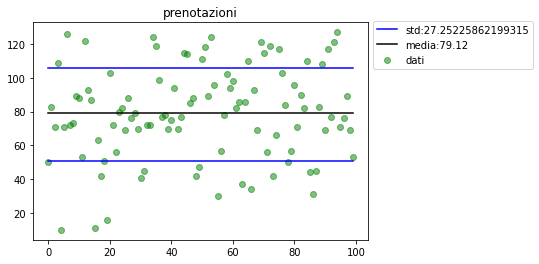

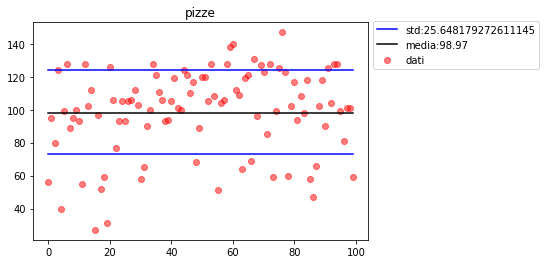

In [319]:
#@title
def print_data(data: np.array, media: float, std: float, color: str, titolo: str):
  # 0-
  x = np.arange(data.size)

  plt.scatter(x, data, color=color, alpha=0.5, label="dati")
  
  plt.plot(x, np.full_like(x, media + std), color="blue",  label="std:" + str(std))
  plt.plot(x, np.full_like(x, media),       color="black", label="media:" + str(media))
  plt.plot(x, np.full_like(x, media - std), color="blue")

  plt.title(titolo)
  plt.legend(bbox_to_anchor=(1., 1.03)) 
  plt.show()


print_data(prenotazioni, medie_prenotazioni, std_prenotazioni, "green", "prenotazioni")
print_data(pizze,        medie_pizze,        std_pizze,        "red",   "pizze")

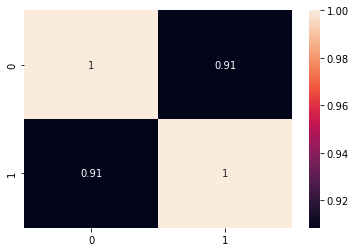

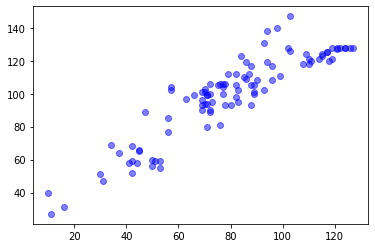

In [320]:
#@title
import seaborn as sns


corr = np.corrcoef(prenotazioni, pizze)
sns.heatmap(corr, annot=True)
plt.show()

plt.scatter(prenotazioni, pizze, color="blue", alpha=0.5, label="datai")
plt.show()

# **REGRESSIONE LINEARE**




Se tra due vairabili è riscontrabile  una qualche relazione di dipendenza, è possibile stabilire la predizione di un varabile in funzione del valore assunto dall'altra.

Il modello più semplide di relazione tra variabili è quello lineare, rappresentato da una reta la cui equazione é:

\begin{align}
  y = ax + b        
\end{align}
a = coefficiente angolare
\
b = interctta (bias)


In [321]:
#@title
def regression_line(x: np.array, a: float, b: float) -> np.array:
  y = (a * x) + b
  return y

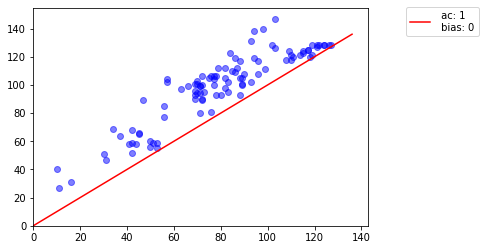

In [322]:
#@title
def plot_linear_regression(ft: np.array, lbs: np.array, a:float, b: float):
  x = np.arange(np.max(ft + 10))
  y = regression_line(x, a, b)

  labels = " ac: " + str(a)  + "\n bias: " + str(b)
  plt.plot(x, y, color="red", label=labels)
  plt.scatter(ft, lbs, color="blue", alpha=0.5)
  plt.xlim(0)
  plt.ylim(0)
  plt.legend()
  plt.legend(bbox_to_anchor=(1.1, 1.03)) 
  plt.show()


plot_linear_regression(prenotazioni, pizze, 1, 0)

# **FASE DI TRAINING**

Sostituiamo la "x" e la "y" nella nostra equazione di partenza con i nostri dati etichettati.

\begin{align}
  pizze = (a * prenotazioni) + b       
\end{align}


Trovato il modello matematico, va quindi cercato l'algoritmo  per trovare i valori dei parametri "a" e "b", in grado di sintetizzare al meglio l'andamento dei dati.



## **Stima dell'errore**


\
Partiamo valutando l'errore che otteniamo cercando di **volta** in volta i parametri "a" e "b".

In matematica, la funzione deputata a questo tipo di compito si chiama *funzione obiettivo* o *funzione di perdita* (*loss function*)







\

\begin{align}
        l = \dfrac{err_1^2 + err_2^2 + err_3^2 + ... + err_n^2}{n} = \dfrac{1}{n} \sum_{i=1}^n ((ax_i + b) - ŷ_i)^2  =  \dfrac{1}{n} \sum_{i=1}^n (y_i - ŷ_i)^2 = media(quadrato(errore(costo))))
\end{align}


\

La fase di addestramento si basa fondamentalmente sulla **minimizazione della funzione di perdita**. Trovare "a" e "b" in modo che questa funzione mi dia un valore che tenda il più possibile a zero


In [323]:
#@title
def loss(x: np.array, y: np.array, a: float, b: float):
  return np.average( (regression_line(x, a, b) -  y) ** 2) 


## **Primo tentativo di addestramento**


Proviamo ad iterare n volte aggiungendo o sottraendo un valore costante (**learnin rate**), in modo da trovare i paramentri "a" e "b" che minimizzino al meglio la funzione di perdita.

In [324]:
#@title
def train_1(x: np.array, y: np.array, it: int, lr: float):
  a = 0.
  b = 0.
  for i in range(it):
    crnt_loss = loss(x, y, a, b)
    if i % 10 == 0:
      print("iter={:d}    a={:.2f}    b={:.4f}    loss={:.5}".format(i, a, b, loss(x, y, a, b)))

    if   ( loss(x, y, a + lr,  b)      < crnt_loss ): a += lr
    elif ( loss(x, y, a - lr,  b)      < crnt_loss ): a -= lr
    elif ( loss(x, y, a,       b + lr) < crnt_loss ): b += lr
    elif ( loss(x, y, a,       b - lr) < crnt_loss ): b -= lr
    else: return a,b

  print("WARNING ")

a1, b1 = train_1(prenotazioni, pizze, it=10000, lr=0.1)




iter=0    a=0.00    b=0.0000    loss=1.0453e+04
iter=10    a=1.00    b=0.0000    loss=524.49
iter=20    a=1.20    b=0.8000    loss=213.65
iter=30    a=1.20    b=1.8000    loss=208.19
iter=40    a=1.20    b=2.8000    loss=204.74
iter=50    a=1.20    b=3.8000    loss=203.29


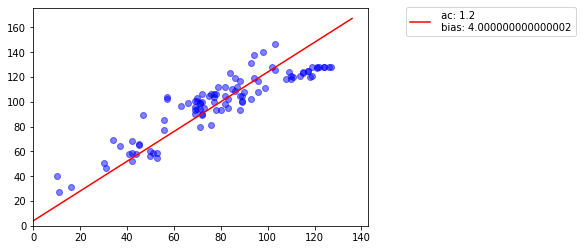

In [325]:
plot_linear_regression(prenotazioni, pizze, a1, b1)


## **Primo tentativo di Predizione**

In [326]:
#@title

# test predizione

i1 = np.random.randint(0, prenotazioni.size - 1)
i2 = np.random.randint(0, prenotazioni.size - 1)
i3 = np.random.randint(0, prenotazioni.size - 1)

t1 = [prenotazioni[i1], pizze[i1]]
t2 = [prenotazioni[i2], pizze[i2]]
t3 = [prenotazioni[i3], pizze[i3]]

p1 = a1 * t1[0] + b1
p2 = a1 * t2[0] + b1
p3 = a1 * t3[0] + b1


print("numero: %.f,  predizione: %.3f , atteso: %.f" % (t1[0], p1, t1[1])) 
print("numero: %.f,  predizione: %.3f , atteso: %.f" % (t2[0], p2, t2[1])) 
print("numero: %.f,  predizione: %.3f , atteso: %.f" % (t3[0], p3, t3[1])) 





numero: 87,  predizione: 108.400 , atteso: 112
numero: 69,  predizione: 86.800 , atteso: 93
numero: 71,  predizione: 89.200 , atteso: 99


# **Discesa del gradiente**

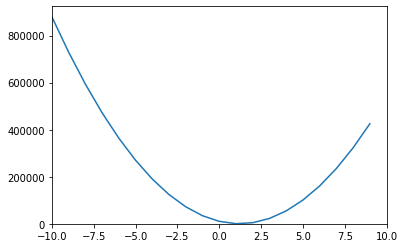

In [327]:
la = np.arange(-10, 10)
ly = np.zeros_like(la)
for i in range(la.size):
  ly[i] = loss(prenotazioni, pizze, la[i], 0)

plt.plot(la, ly) 
plt.ylim(0)
plt.xlim(-10,10)
plt.show() 


## **Considerazioni sulla funzione di costo**

- La funzione di costo  è sempre continuna in ogni suo punto 
- ha una forma regolare

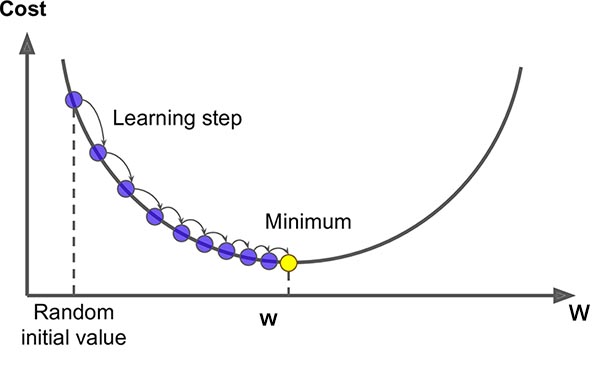

## **Il rapporto incrementale**


Cominciamo a ragionare partendo dal solo coefficiente angolare "a" e osserviamo cosa accade nella funzione di costo se fissiamo un intorno di un punto determinato da un valore di "a" a piacere.

\

Quidi, riassumendo in termini matematici la nostra funzione sarà:

\begin{align}
  f(a) = loss(a) 
\end{align}

E l'intorno della nostra funzione rispetto ad un valore di "a" sarà dato da:

\begin{align}
  I(a) = (a - h, \ a, \ a + h)
\end{align}

Quindi da "a" a cui sommiamo una certa quantità "h"

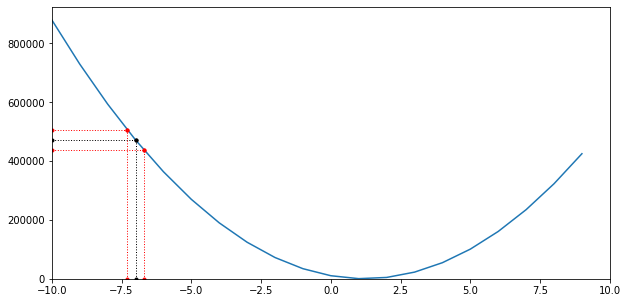

In [328]:
from matplotlib import animation
# =================
# da usare in Colab
# =================
from IPython.display import HTML



fig, ax = plt.subplots(figsize=(10, 5))



la = np.arange(-10, 10)
ly = np.zeros_like(la)
for p in range(la.size):
  ly[p] = loss(prenotazioni, pizze, la[p], 0)

line, = ax.plot(la, ly)



h = 0.3;
test_a_x = la[3]
test_a_x_1 = test_a_x - h
test_a_x_2 = test_a_x + h
test_a_y   = loss(prenotazioni, pizze, test_a_x,  0);
test_a_y_1 = loss(prenotazioni, pizze, test_a_x_1, 0)
test_a_y_2 = loss(prenotazioni, pizze, test_a_x_2, 0)




plot_a_v,   = ax.plot([-10, test_a_x],   [test_a_y,   test_a_y],   color = "black", marker = '.', ls = ':',  linewidth = '1.') 
plot_a_1_v, = ax.plot([-10, test_a_x_1], [test_a_y_1, test_a_y_1], color= "red", marker = '.',  ls = ':', linewidth = '1.')
plot_a_2_v, = ax.plot([-10, test_a_x_2], [test_a_y_2, test_a_y_2], color="red", marker = '.',  ls = ':', linewidth = '1.')

plot_a_o,   = ax.plot([test_a_x, test_a_x],     [0,  test_a_y],   color = "black", marker = '.',ls = ':', linewidth = '1.')
plot_a_1_o, = ax.plot([test_a_x_1, test_a_x_1], [0,  test_a_y_1], color = "red",   marker = '.',ls = ':', linewidth = '1.')
plot_a_2_o, = ax.plot([test_a_x_2, test_a_x_2], [0,  test_a_y_2], color = "red",   marker = '.',ls = ':', linewidth = '1.')



def init():
  return plot_a_v, plot_a_1_v, plot_a_2_v,  plot_a_o, plot_a_1_o, plot_a_2_o




crnt_a_x = -10.
def animate(i):
  learning_rate = 0.5

  global crnt_a_x
  crnt_a_x += learning_rate
  a_x_1     = crnt_a_x - h
  a_x_2     = crnt_a_x + h

  a_y   = loss(prenotazioni, pizze, crnt_a_x,  0);
  a_y_1 = loss(prenotazioni, pizze, a_x_1, 0)
  a_y_2 = loss(prenotazioni, pizze, a_x_2, 0)

  plot_a_v.set_xdata([-10, crnt_a_x])
  plot_a_v.set_ydata([a_y,   a_y]) 
  plot_a_1_v.set_xdata([-10, a_x_1])
  plot_a_1_v.set_ydata([a_y_1, a_y_1]) 
  plot_a_2_v.set_xdata([-10, a_x_2])
  plot_a_2_v.set_ydata([a_y_2, a_y_2]) 


  plot_a_o.set_xdata([crnt_a_x, crnt_a_x])
  plot_a_o.set_ydata([0,  a_y]) 
  plot_a_1_o.set_xdata([a_x_1, a_x_1])
  plot_a_1_o.set_ydata([0,  a_y_1]) 
  plot_a_2_o.set_xdata([a_x_2, a_x_2])
  plot_a_2_o.set_ydata([0,  a_y_2]) 

  ax.set_title("delta x = %.2f   delta y = %.f" % (a_x_2 - crnt_a_x, a_y - a_y_2)) 
  return plot_a_v, plot_a_1_v, plot_a_2_v,  plot_a_o, plot_a_1_o, plot_a_2_o


anim = animation.FuncAnimation(fig,
                               animate, 
                                np.arange(23), 
                                init_func=init,
                                interval=500, blit=True)    

plt.ylim(0)
plt.xlim(-10,10)
plt.show()


Osserviamo come al variare di "a", l'intorno costruito sull'asse delle ascisse determini un intorno sull'asse delle ordinate che va sempre più restringendosi tendendo a zero con l'avvicinarsi al valore minimo della funzione.

Nel grafico si ha:

- **delta x**: definisce lo spazio qullo che viene chiamato l'intorno destro rispetto ad "a" sulle ascisse.
\begin{align}
  \delta_{x+} = (a + h) - a
\end{align}

- **delta y**: definisce lo spazio a destr di f(a) sulle oridnate.
\begin{align}
  \delta_{y+} =  f(a + h) - f(a)
\end{align}





In [329]:
# Funzione per avviare l'animazione
HTML(anim.to_jshtml())

Il prossimo passo è formazlizzare questa relazione attraverso il **rapporto incrementale**, cioè il rapporto tra l'incremento sull'asse delle ascisse e l'incremento sulle ordinate.
\begin{align}
  \frac{\Delta y}{\Delta a} = \frac{f(a + h) - f(a)}{(a + h) - a} = \frac{f(a + h) - f(a)}{h}
\end{align}


## **La derivata**

In matematica la derivata è la valutazione del rapporto incrementale al tendere a 0 dell'incremento.

Formalmente abbiamo:
\begin{align}
  f'(a) = \lim_{h\to 0}	 \frac{f(a + h) - f(a)}{h}
\end{align}

Tralasciando il calcolo delle derivate passiamo direttamente alla formulazione della derivata della funzione di costo, che sarà la base della nuova funzione per "minimizzare" la distanza tra il nostro modello di ml e la sua etichetta.


Nel nostro caso, la nostra equazione dipende da due variabili "a" e "b". 
In questo caso si parla di **derivate parziali** il cui risultato viene definito appunto **gradiente**.


\begin{align}
   \frac{\partial l}{\partial a}= \frac{2}{n}  \sum_{i=1}^n x_i((ax_i + b) - ŷ_i)
\end{align}


\begin{align}
   \frac{\partial l}{\partial b}= \frac{2}{n}  \sum_{i=1}^n ((ax_i + b) - ŷ_i)
\end{align}



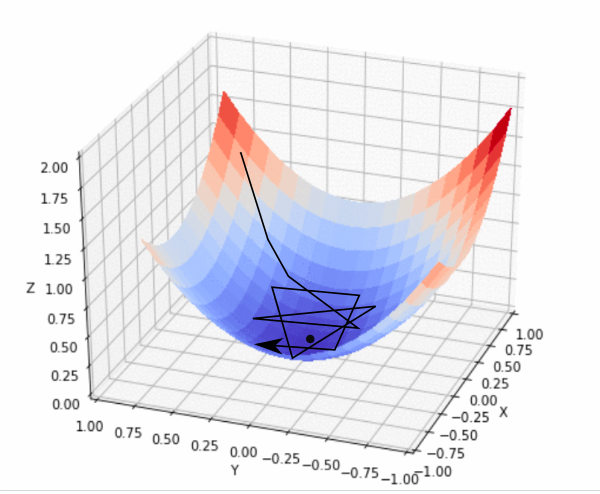

In [330]:
def gradient(x: np.array, y: np.array, a: float, b: float):
  loss = ((x * a) + b) - y
  da = 2 * np.average( x * loss)
  db = 2 * np.average(loss)
  return da, db

# **Addestramento per regressione lineare con discesa del gradiente**

In [331]:
def linear_regression_train(x: np.array, y: np.array, it: int, lr: float):
  a = b = 0.0
  for i in range(it):
    da, db = gradient(x, y, a, b)
    a -= da * lr
    b -= db * lr
    # Log 
    if i % 10 == 0:
      print("iter={:d}    a={:.2f}    b={:.4f}    loss={:.2}".format(i, a, b, loss(x, y, a, b)))
  return a, b

# **Predizione da regressione lineare con dicscesa del gradiente**

In [ ]:


a, b = linear_regression_train(prenotazioni, pizze, 10000, 0.0001)


iter=0    a=1.69    b=0.0198    loss=1.9e+03
iter=10    a=1.21    b=0.0210    loss=2.2e+02
iter=20    a=1.21    b=0.0276    loss=2.2e+02
iter=30    a=1.21    b=0.0342    loss=2.2e+02
iter=40    a=1.21    b=0.0409    loss=2.2e+02
iter=50    a=1.21    b=0.0475    loss=2.2e+02
iter=60    a=1.21    b=0.0541    loss=2.2e+02
iter=70    a=1.21    b=0.0608    loss=2.2e+02
iter=80    a=1.21    b=0.0674    loss=2.2e+02
iter=90    a=1.21    b=0.0740    loss=2.2e+02
iter=100    a=1.21    b=0.0806    loss=2.2e+02
iter=110    a=1.21    b=0.0873    loss=2.2e+02
iter=120    a=1.21    b=0.0939    loss=2.2e+02
iter=130    a=1.21    b=0.1005    loss=2.2e+02
iter=140    a=1.21    b=0.1071    loss=2.2e+02
iter=150    a=1.21    b=0.1138    loss=2.2e+02
iter=160    a=1.21    b=0.1204    loss=2.2e+02
iter=170    a=1.21    b=0.1270    loss=2.2e+02
iter=180    a=1.21    b=0.1336    loss=2.2e+02
iter=190    a=1.21    b=0.1402    loss=2.2e+02
iter=200    a=1.21    b=0.1468    loss=2.2e+02
iter=210    a=1.21    b=

In [ ]:
plot_linear_regression(prenotazioni, pizze, a, b)

In [ ]:


p1 = (a * t1[0]) + b
p2 = (a * t2[0]) + b
p3 = (a * t3[0]) + b


print("numero: %.f,  predizione: %.3f , atteso: %.f" % (t1[0], p1, t1[1])) 
print("numero: %.f,  predizione: %.3f , atteso: %.f" % (t2[0], p2, t2[1])) 
print("numero: %.f,  predizione: %.3f , atteso: %.f" % (t3[0], p3, t3[1])) 






---



# **La libreria scikit-learn**


---



In [ ]:
from sklearn.linear_model import LinearRegression


# ADDESTRAMENTO

# instansizamento della class LinearRegression
lr = LinearRegression()

# fit(x,y) avvia la classe di trainint
#  scikit-learn richiede che i dati delle features (x)
#  siano disposti in colonna.
# in numpy per convertire un array in una matrice 1xN si usa 
# la funzione reshape(-1,1)
lr.fit( prenotazioni.reshape(-1,1), pizze)


a = lr.coef_
b = lr.intercept_
plot_linear_regression(prenotazioni, pizze, a, b)


## **Training, Validation, Test**

Di norma un set di dati viene suddiviso al più in tre blocchi.

- **Training set**: il set di dati usato in fase di addestramento.
- **Validation set**: il set utilizzato per valutare il modello mentre si regolano gli iperparametri del modello scelto.
- **Test set**: il set usato per la valutazione finale della fase di training.

Facciamo una prima prova senza intervenire ulteriormente nel dataset, basandoci esclusivamente sulla divisione tra ***training set*** e ***test set***.

***train_test_split*** è il modulo di ***scikit-learn*** per lo split dei dati.

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(prenotazioni.reshape(-1, 1), pizze, test_size=0.2)


In [ ]:

lr.fit(x_train, y_train)

a = lr.coef_
b = lr.intercept_
plot_linear_regression(prenotazioni, pizze, a, b)


# **Radice dell'rrore quadratico medio**

Non è altro che la deviazione standard delle distanze (errori) tra valore predetto e valore atteso.



\begin{align}
      RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - ŷ_i)^2}
\end{align}

In [ ]:
from sklearn.metrics import mean_squared_error

pred_1 = lr.predict(x_test)

mse_test_1 = mean_squared_error(y_test, pred_1)
rmse_test_1 = np.sqrt(mse_test_1)

print(pizze.max(), pizze.min())
print(f"STIMA DELL'ERRORE MEDIO NELLA PREDIZIONE DELLE ETICHETTE: {rmse_test_1}")

**punteggio R2**


Indica la percentuale di varianza che hanno in comune due variabili.

In [ ]:
from sklearn.metrics import r2_score

r2_tst_1 = r2_score(y_test, pred_1)
print(f"LE ETICHETTE PREDETTE E DI TEST HANNO LA STESSA VARIANZA ALL' {r2_tst_1 * 100:.3f}%")

# **Scaling**

Un passo importante da effetuare prima di addetrare un modello è lo "scaling" dei dati. 

La maggior parte dei modelli di ML lavora meglio con insiemi di valori delimitati in un range preciso e limitato.

Le principali metodologie di scaling sono:
**normalizzazione** e **standardizzazione**


## Normalizzazione
\begin{align}
  z = \frac{x - x_{min}}{ x_{max} - x_{min}}
\end{align}


Scala i valori in un rage che va da 0 a 1. 
La distribuzione resta inalterata, il rapporto interno tra le variabili non cambia, cambia, appunto, solo la scala con ui sono espresse.


In [ ]:
from sklearn.preprocessing import MinMaxScaler


scale_mm = MinMaxScaler() 
prenotazioni_mm_scaled = scale_mm.fit_transform( prenotazioni.reshape(-1,1))
pizze_mm_scaled        = scale_mm.fit_transform(pizze.reshape(-1, 1)).flatten()



**Inversa della normalizzazione**

In [ ]:
def reverse_scale_min_max(z):
  x_min = np.min(prenotazioni)
  y_max = np.max(prenotazioni)
  return (z * (y_max - x_min)) + x_min



**SPLIT**

In [ ]:
x_train_mm, x_test_mm, y_train_mm, y_test_mm = train_test_split(prenotazioni_mm_scaled, 
                                                                pizze_mm_scaled, 
                                                                test_size=0.2)


**TRAINING**

In [ ]:
lr.fit(x_train_mm, y_train_mm)

a = lr.coef_
b = reverse_scale_min_max(lr.intercept_)
plot_linear_regression(prenotazioni, pizze, a, b)


**TEST**

In [ ]:

# RMSE
pred_mm = lr.predict(x_test_mm)

mse_test_mm = mean_squared_error(y_test_mm, pred_mm)
rmse_test_mm = np.sqrt(mse_test_mm)

print(pizze.max(), pizze.min())
print(f"STIMA DELL'ERRORE MEDIO NELLA PREDIZIONE DELLE ETICHETTE: {rmse_test_mm}")



# R2
r2_tst_mm = r2_score(y_test_mm, pred_mm)
print(f"LE ETICHETTE PREDETTE E DI TEST HANNO LA STESSA VARIANZA AL : {r2_tst_mm * 100:.3f}%")

## Standardizzazione

Per effettuare la standardizzazione basterà sostituire ogni variabile con il rispettivo z-score. 

\begin{align}
  z = \frac{x - \mu}{\sigma}
\end{align}

È molto utile quando una distribuzione ha una forma "Gaussiana" è può essere sostituita con una rappresentazione più semplice.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()

prenotazioni_std_scaled = scaler_std.fit_transform( prenotazioni.reshape(-1,1))
pizze_std_scaled        = scaler_std.fit_transform(pizze.reshape(-1, 1)).flatten()


**invsersa della standardizzazione**

In [ ]:
def revers_scale_std(z):
  return (z * np.std(prenotazioni)) + np.mean(prenotazioni) 

**TRAINING**

In [ ]:
lr.fit(prenotazioni_std_scaled, pizze_std_scaled)

a = lr.coef_
b = revers_scale_std(lr.intercept_)
plot_linear_regression(prenotazioni, pizze, a, b)


# **Problemi di adattamento**


- **overfitting**: il modello scelto viene addestrato in modo da aderire così perfettamente al set di treaning che non saprà come comportarsi con i dati di test o i nuovi dati.
Possiamo paragonare questo problema allo studio effettuato "imparando a memoria" un teto.

- **underfitting**: il modello scelto non è in grado di apprendere abbastaza da poter dare risultati efficaci. Questo problema sopraggiunge soprattutto quando la quantità di dati a disposizione è piuttosto esigua.


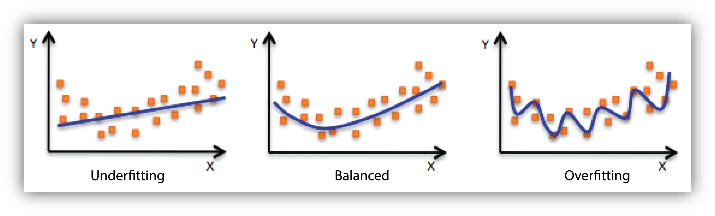